# Imports

In [1]:
import os
import sys
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import LeaveOneOut

# Add the absolute path to the root directory
script_dir = os.path.abspath('.')
root_dir = os.path.dirname(script_dir)
sys.path.insert(0, root_dir)

from data import *
from tqdm import tqdm

dataset_root = os.path.join(script_dir, "serialized")

## Global Common

In [2]:
import sklearn
from scipy import stats, integrate
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

def overlap_area(A, B):
    """Compute the overlap area between the two PDFs"""
    pdf_A = stats.gaussian_kde(A)
    pdf_B = stats.gaussian_kde(B)
    return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


def kl_dist(A, B, num_sample=1000):
    """Compute the KL distance and overlap area between the two PDFs"""
    pdf_A = stats.gaussian_kde(A)
    pdf_B = stats.gaussian_kde(B)
    sample_A = np.linspace(np.min(A), np.max(A), num_sample)
    sample_B = np.linspace(np.min(B), np.max(B), num_sample)
    return stats.entropy(pdf_A(sample_A), pdf_B(sample_B))


def plot_kld_oa_per_feature(per_feature_dists, modelA_name="MidiNet 1", modelB_name="MidiNet 2"):
    """
    Plots a KLD vs OA comparison plot across features, with one marker per model per feature
    """
    feature_labels = list(per_feature_dists.keys())
    fig, ax = plt.subplots(figsize=(8, 6))
    markers = {"A": "^", "B": "o", }
    colors = sns.color_palette("hls", n_colors=len(feature_labels))

    for i, feature in enumerate(feature_labels):
        A_flat = per_feature_dists[feature]["A_intra"][np.triu_indices_from(per_feature_dists[feature]["A_intra"], k=1)]
        B_flat = per_feature_dists[feature]["B_intra"][np.triu_indices_from(per_feature_dists[feature]["B_intra"], k=1)]
        if per_feature_dists[feature]["baseline_intra"] is None:
            raise ValueError(f"Baseline is not provided for feature {feature}")
        baseline_flat = per_feature_dists[feature]["baseline_intra"][np.triu_indices_from(per_feature_dists[feature]["baseline_intra"], k=1)]
        kld_A_baseline = kl_dist(A_flat, baseline_flat)
        kld_B_baseline = kl_dist(B_flat, baseline_flat)
        oa_A_baseline = overlap_area(A_flat, baseline_flat)
        oa_B_baseline = overlap_area(B_flat, baseline_flat)

        # Plot points
        ax.scatter(kld_A_baseline, oa_A_baseline, marker=markers["A"], color=colors[i], s=100, label=f"{i+1}: {feature}")
        ax.scatter(kld_B_baseline, oa_B_baseline, marker=markers["B"], color=colors[i], s=100, label=f"{i+1}: {feature}")

        # Line connecting both models for this feature
        ax.plot([kld_A_baseline, kld_B_baseline], [oa_A_baseline, oa_B_baseline], linestyle='--', color=colors[i], linewidth=1)

    ax.set_xlabel("KLD")
    ax.set_ylabel("OA")
    ax.set_title("KLD vs OA per Feature")
    legend_elements = [
        plt.Line2D([0], [0], marker=markers["A"], color='w', label=modelA_name, markerfacecolor='gray', markersize=8),
        plt.Line2D([0], [0], marker=markers["B"], color='w', label=modelB_name, markerfacecolor='gray', markersize=8),
    ]
    legend_elements.extend([plt.Line2D([0], [0], marker='_', color=colors[i], label=feature) for i, feature in enumerate(feature_labels)])
    ax.legend(handles=legend_elements, loc='lower left', fontsize=10)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def compute_1d_intra_distances(x, normalize=False):
    """Computes all pairwise distances within a 1D array"""
    # Calculate unique pairwise distances
    x = x.reshape(-1, 1)
    if normalize:
        x = sklearn.preprocessing.normalize(x, norm='l1')
    intra_distances = cdist(x, x, metric='euclidean')
    return intra_distances

def compute_1d_inter_distances(x, y, normalize=False):
    """Computes all pairwise distances between two 1D arrays"""
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    if normalize:
        x = sklearn.preprocessing.normalize(x, norm='l1')
        y = sklearn.preprocessing.normalize(y, norm='l1')
    inter_distances = cdist(x, y, metric='euclidean')
    return inter_distances

def compute_per_feature_distances(A_dict : dict, B_dict : dict, baseline_dict : dict = None):
    per_feature_dists = {}
    for feature in tqdm(A_dict.keys(), desc="Computing per-feature distances"):
        A_feat = A_dict[feature]
        B_feat = B_dict[feature]
        per_feature_dists[feature] = {
            "A_intra": compute_1d_intra_distances(A_feat),
            "B_intra": compute_1d_intra_distances(B_feat),
            "baseline_intra": None if baseline_dict is None else compute_1d_intra_distances(baseline_dict[feature]),
            "AB_inter": compute_1d_inter_distances(A_feat, B_feat),
            "A_baseline_inter": None if baseline_dict is None else compute_1d_inter_distances(A_feat, baseline_dict[feature]),
            "B_baseline_inter": None if baseline_dict is None else compute_1d_inter_distances(B_feat, baseline_dict[feature]),
        }
    return per_feature_dists

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_kde_grid_per_feature(
    per_feature_dists, 
    A_label="A", 
    B_label="B", 
    baseline_label="Baseline",
    figsize=(12, 8),
    ncols=2,
    nrows=None,
    hspace=0.3,
    wspace=0.2
):
    features = list(per_feature_dists.keys())
    n_features = len(features)
    if nrows is None:
        nrows = int(np.ceil(n_features / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    palette = sns.color_palette("colorblind", 6)
    label_color_map = {
        f"Intra {A_label}": palette[0],
        f"Intra {B_label}": palette[1],
        f"Inter {A_label}–{B_label}": palette[2],
        f"Intra {baseline_label}": palette[3],
        f"Inter {A_label}–{baseline_label}": palette[4],
        f"Inter {B_label}–{baseline_label}": palette[5],
    }
    for idx, feature in enumerate(features):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]
        dists = per_feature_dists[feature]
        # Plot each distribution with shading and assigned color
        if dists.get("A_intra") is not None:
            sns.kdeplot(
                dists["A_intra"].flatten(), 
                label=f"Intra {A_label}", 
                fill=True, 
                color=label_color_map[f"Intra {A_label}"],
                ax=ax
            )
        if dists.get("B_intra") is not None:
            sns.kdeplot(
                dists["B_intra"].flatten(), 
                label=f"Intra {B_label}", 
                fill=True, 
                color=label_color_map[f"Intra {B_label}"],
                ax=ax
            )
        if dists.get("AB_inter") is not None:
            sns.kdeplot(
                dists["AB_inter"].flatten(), 
                label=f"Inter {A_label}–{B_label}", 
                fill=True, 
                color=label_color_map[f"Inter {A_label}–{B_label}"],
                ax=ax
            )
        if dists.get("baseline_intra") is not None:
            sns.kdeplot(
                dists["baseline_intra"].flatten(), 
                label=f"Intra {baseline_label}", 
                fill=True, 
                color=label_color_map[f"Intra {baseline_label}"],
                ax=ax
            )
        if dists.get("A_baseline_inter") is not None:
            sns.kdeplot(
                dists["A_baseline_inter"].flatten(), 
                label=f"Inter {A_label}–{baseline_label}", 
                fill=True, 
                color=label_color_map[f"Inter {A_label}–{baseline_label}"],
                ax=ax
            )
        if dists.get("B_baseline_inter") is not None:
            sns.kdeplot(
                dists["B_baseline_inter"].flatten(), 
                label=f"Inter {B_label}–{baseline_label}", 
                fill=True, 
                color=label_color_map[f"Inter {B_label}–{baseline_label}"],
                ax=ax
            )
        ax.set_title(f"KDE: {feature}")
        ax.set_xlabel("Distance")
        ax.set_ylabel("Density")
        ax.legend()
    # Hide any unused axes
    for idx in range(n_features, nrows * ncols):
        row, col = divmod(idx, ncols)
        fig.delaxes(axes[row][col])
    fig.tight_layout()
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    return fig, axes

def plot_violin_per_feature(per_feature_dists, base_width_per_feature=2.5, height=10, A_label="A", B_label="B"):
    """
    Plots a combined violin plot across features for each intra-set distance.
    """
    records = []

    for feature, dists in per_feature_dists.items():
        A_dists = dists["A_intra"]
        B_dists = dists["B_intra"]

        # Flatten upper triangle (excluding diagonal)
        A_flat = A_dists[np.triu_indices_from(A_dists, k=1)]
        B_flat = B_dists[np.triu_indices_from(B_dists, k=1)]
        all_vals = np.concatenate([A_flat, B_flat])
        mean, std = np.mean(all_vals), np.std(all_vals)

        records.extend([{"Feature": feature, "Distance": (val - mean) / std, "Model": A_label} for val in A_flat])
        records.extend([{"Feature": feature, "Distance": (val - mean) / std, "Model": B_label} for val in B_flat])

    df = pd.DataFrame(records)
    num_features = df["Feature"].nunique()
    width = base_width_per_feature * num_features

    plt.figure(figsize=(width, height))
    sns.violinplot(data=df, x="Feature", y="Distance", hue="Model", split=True, inner="box", palette="colorblind")
    plt.title("Intra-Set Distance Distribution per Feature")
    plt.tight_layout()
    plt.show()

Computing per-feature distances: 100%|██████████| 2/2 [00:00<00:00, 261.55it/s]


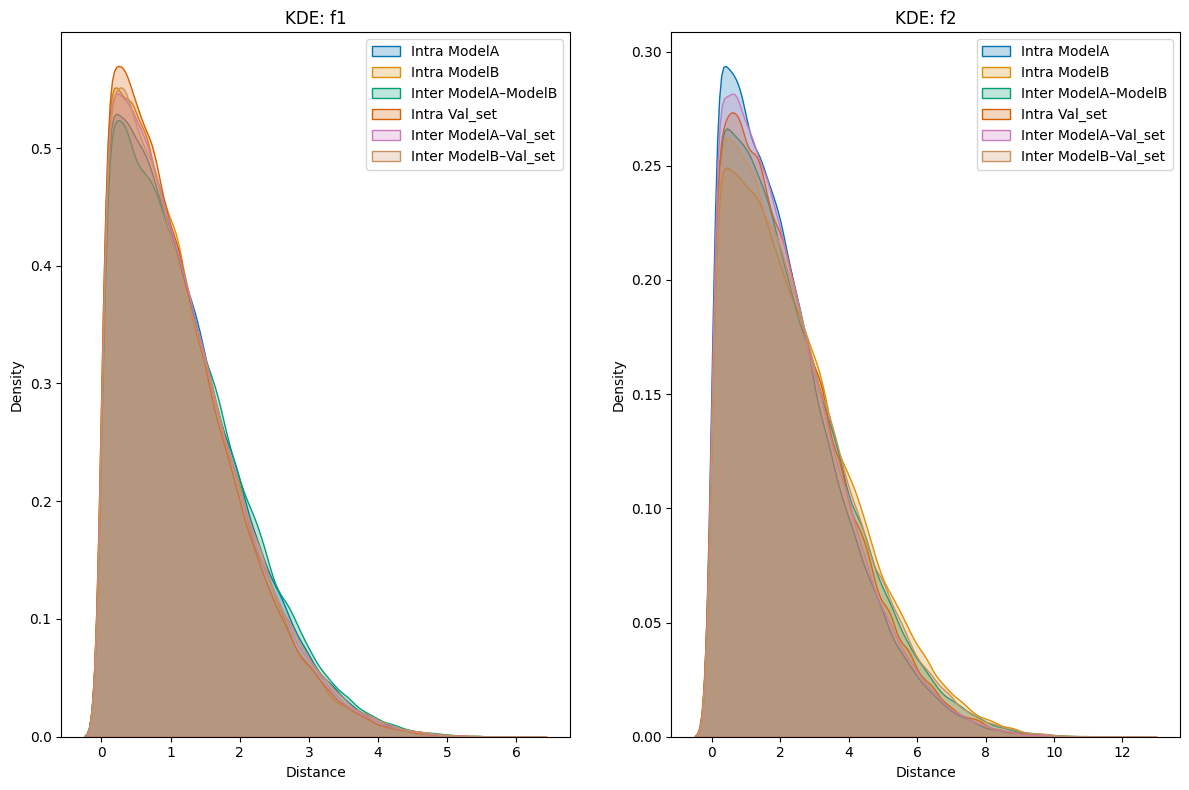

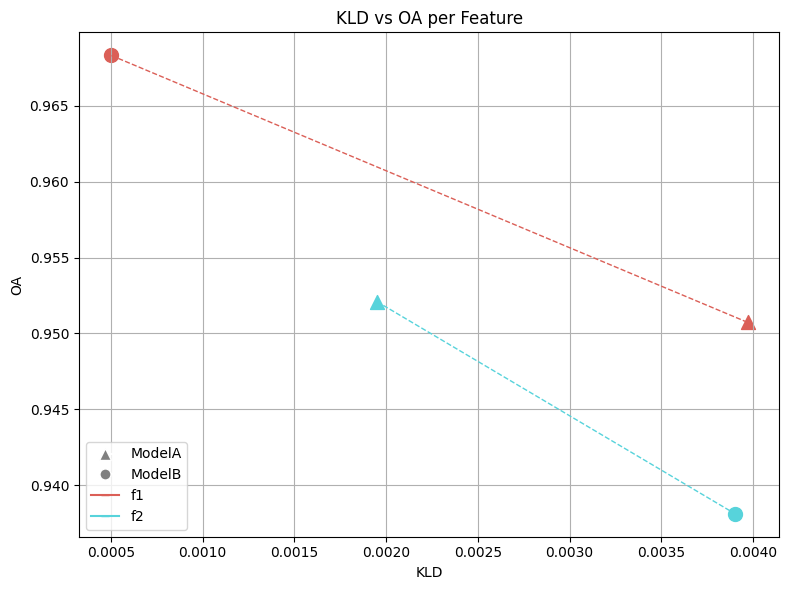

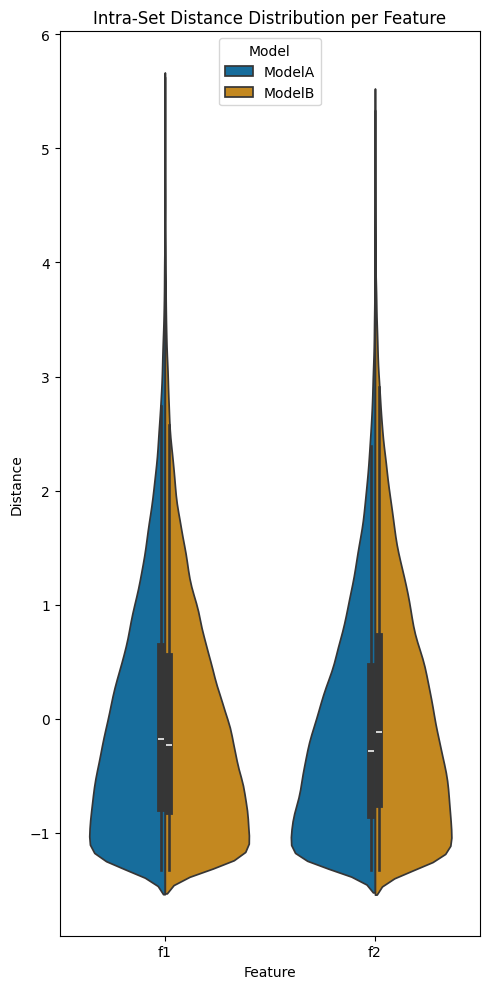

In [34]:
val_dict = {
    "f1": np.random.normal(0, 1, 400),
    "f2": np.random.normal(5, 2, 400),
}

A_dict = {
    "f1": np.random.normal(0, 1, 400),
    "f2": np.random.normal(5, 2, 400),
}

B_dict = {
    "f1": np.random.normal(0.5, 1, 400),
    "f2": np.random.normal(4.5, 2, 400),
}

dists = compute_per_feature_distances(A_dict, B_dict, baseline_dict=val_dict)
plot_kde_grid_per_feature(dists, A_label="ModelA", B_label="ModelB", baseline_label="Val_set")
plot_kld_oa_per_feature(dists, modelA_name="ModelA", modelB_name="ModelB")
plot_violin_per_feature(dists, A_label="ModelA", B_label="ModelB")


## Absolute Measurement Analysis Between 2Bar-GrooveIQ and 2bar-GMD

### GrooveIQ Dataset

In [3]:
giq_paths    = ['merged_ts=4-4_2bar_tr0.80-va0.10-te0.10_val.pkl', 'merged_ts=4-4_2bar_tr0.80-va0.10-te0.10_test.pkl', 'merged_ts=4-4_2bar_tr0.80-va0.10-te0.10_train.pkl']
name         = "GrooveIQ"

dataset = []
for path in giq_paths:
    with open(os.path.join(dataset_root, path), "rb") as f:
        dataset.extend(pickle.load(f))

GrooveIQStats = DataStats()
GrooveIQStats.set_name(name = name)

for datapoint in tqdm(dataset):
    GrooveIQStats.accumulate_dict(datapoint)

100%|██████████| 383511/383511 [06:29<00:00, 984.69it/s] 


In [ ]:
GrooveIQStats.visualize()
GrooveIQStats.summarize()

#### Feature Statistics

In [10]:
## Absolute Measurements
giq_eval_dict = defaultdict(list)

for sample in tqdm(GrooveIQStats.all_samples):
    descriptors = sample.descriptors.descriptors
    for key, value in descriptors.items():
        giq_eval_dict[key].append(value)

giq_eval_dict = {key: np.array(value) for key, value in giq_eval_dict.items()}

for key, value in giq_eval_dict.items():
    print(f"{key:30}: mean={np.mean(value):.2f}, std={np.std(value):.2f}")


100%|██████████| 383511/383511 [00:01<00:00, 243922.93it/s]


total_density                 : mean=0.07, std=0.03
total_complexity              : mean=0.55, std=0.39
total_average_intensity       : mean=0.72, std=0.15
lowness                       : mean=0.20, std=0.16
midness                       : mean=0.21, std=0.15
highness                      : mean=0.30, std=0.17
combined_syncopation          : mean=0.54, std=0.39
polyphonic_syncopation        : mean=2.52, std=6.23
laidbackness                  : mean=-0.00, std=0.17
swingness                     : mean=0.26, std=0.45
timing_accuracy               : mean=7.19, std=6.70


### GMD Dataset

In [6]:
GMD_paths    = ['2barGMD.pkl']
name         = "2barGMD"

dataset = []
for path in GMD_paths:
    with open(os.path.join(dataset_root, path), "rb") as f:
        dataset.extend(pickle.load(f))

GMDStats = DataStats()
GMDStats.set_name(name = name)

for datapoint in tqdm(dataset):
    GMDStats.accumulate_dict(datapoint)

100%|██████████| 21383/21383 [00:20<00:00, 1026.57it/s]


In [ ]:
GMDStats.summarize()
GMDStats.visualize()

#### Feature Statistics

In [ ]:
## Absolute Measurements
gmd_eval_dict = defaultdict(list)

for sample in tqdm(GMDStats.all_samples):
    descriptors = sample.descriptors.descriptors
    for key, value in descriptors.items():
        gmd_eval_dict[key].append(value)

for key, value in gmd_eval_dict.items():
    print(f"{key:30}: mean={np.mean(value):.2f}, std={np.std(value):.2f}")

## Note Loss Analysis

In [29]:
note_loss_per_style = {key: [] for key in GrooveIQStats.style_map.keys()}

for sample in tqdm(GrooveIQStats.all_samples):
    _, stats = sample.feature.to_fixed_grid(steps_per_quarter=4)
    note_loss_per_style[sample.style].append(stats['note_loss']/stats['total_notes'])

for style, losses in note_loss_per_style.items():
    print(f"{style:30}: mean={np.mean(losses):.3f}, std={np.std(losses):.3f}")

100%|██████████| 383511/383511 [04:22<00:00, 1462.99it/s]

metal                         : mean=0.028, std=0.061
rock                          : mean=0.017, std=0.047
unknown                       : mean=0.022, std=0.057
latin                         : mean=0.045, std=0.080
jazz                          : mean=0.025, std=0.060
blues                         : mean=0.027, std=0.061
fusion                        : mean=0.039, std=0.066
progressive                   : mean=0.011, std=0.029
country                       : mean=0.019, std=0.049
pop                           : mean=0.024, std=0.058
electronic                    : mean=0.036, std=0.077
rnb                           : mean=0.023, std=0.048
punk                          : mean=0.020, std=0.056
funk                          : mean=0.039, std=0.056
reggae                        : mean=0.032, std=0.055
soul                          : mean=0.015, std=0.034
gospel                        : mean=0.023, std=0.061
hiphop                        : mean=0.047, std=0.078
disco                       

/var/folders/zc/x6z0scxs49z2_22vg5w5xvhw0000gn/T/ipykernel_29482/4177747461.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Style", y="Note Loss", palette=palette, order=style_order, inner="box")


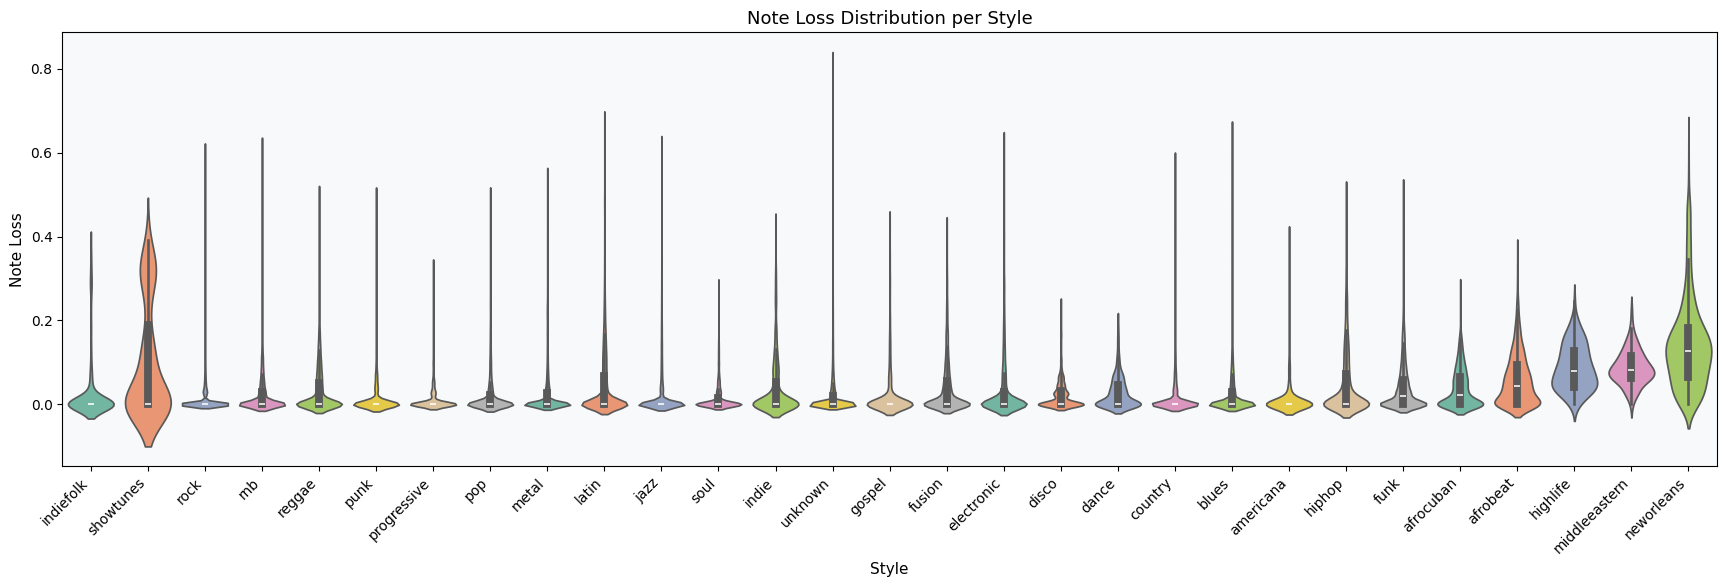

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_note_loss_per_style(note_loss_per_style, palette="tab10"):
    """
    Plots the distribution of note loss per style in a single plot using KDE curves.

    Args:
        note_loss_per_style (dict): Dictionary of {style: list of note loss values}
        palette (str or list): Color palette to use (default: "tab10")
    """
    # Convert to long-form DataFrame
    records = []
    for style, losses in note_loss_per_style.items():
        records.extend([{"Style": style, "Note Loss": val} for val in losses])
    df = pd.DataFrame(records)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x="Note Loss", hue="Style", fill=False, common_norm=False, palette=palette, alpha=0.7, bw_adjust=0.5)
    
    plt.title("Distribution of Note Loss per Style")
    plt.xlabel("Note Loss")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def plot_note_loss_violin(note_loss_per_style, palette="Set2"):
    """
    Plots a violin plot of note loss distributions per style.

    Args:
        note_loss_per_style (dict): Dictionary of {style: list of note loss values}
        palette (str or list): Seaborn color palette name or list of colors
    """
    # Convert to long-form DataFrame
    records = []
    for style, losses in note_loss_per_style.items():
        records.extend([{"Style": style, "Note Loss": val} for val in losses])
    df = pd.DataFrame(records)

    # Sort styles by median note loss (optional, for nicer ordering)
    style_order = df.groupby("Style")["Note Loss"].median().sort_values().index.tolist()

    # Plot
    plt.figure(figsize=(max(8, len(style_order) * 0.6), 6))
    sns.violinplot(data=df, x="Style", y="Note Loss", palette=palette, order=style_order, inner="box")
    
    plt.title("Note Loss Distribution per Style")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()


plot_note_loss_violin(note_loss_per_style)

In [28]:
print(GrooveIQStats.max_hits_per_class)

defaultdict(<class 'int'>, {36: 3, 46: 6, 38: 9, 50: 4, 47: 4, 51: 6, 42: 5, 49: 5, 43: 4})


{'total_notes': 77, 'note_loss': 7}


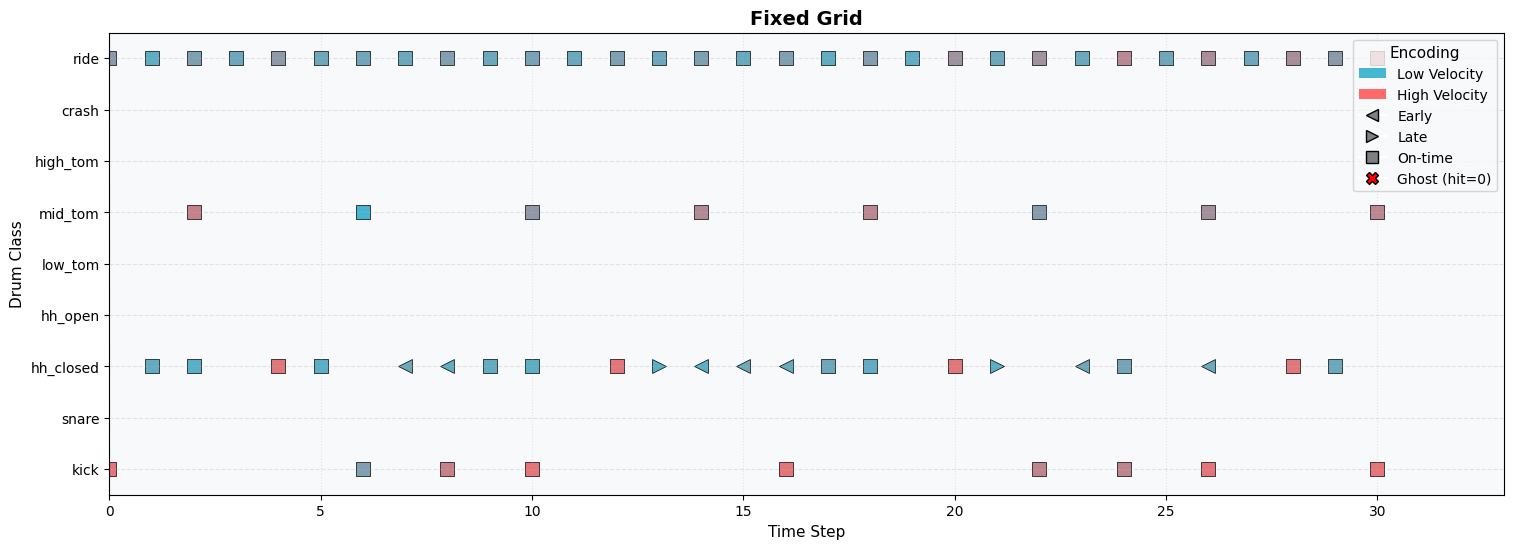

In [42]:
rand_idx = random.randint(0, len(GrooveIQStats.all_samples))
rand_sample = GrooveIQStats.all_samples[rand_idx]

feature = rand_sample.feature
fixed_grid, stats = feature.to_fixed_grid(steps_per_quarter=4)
feature.fixed_grid_plot(steps_per_quarter=4)
print(stats)

{'total_notes': 77, 'note_loss': 0}


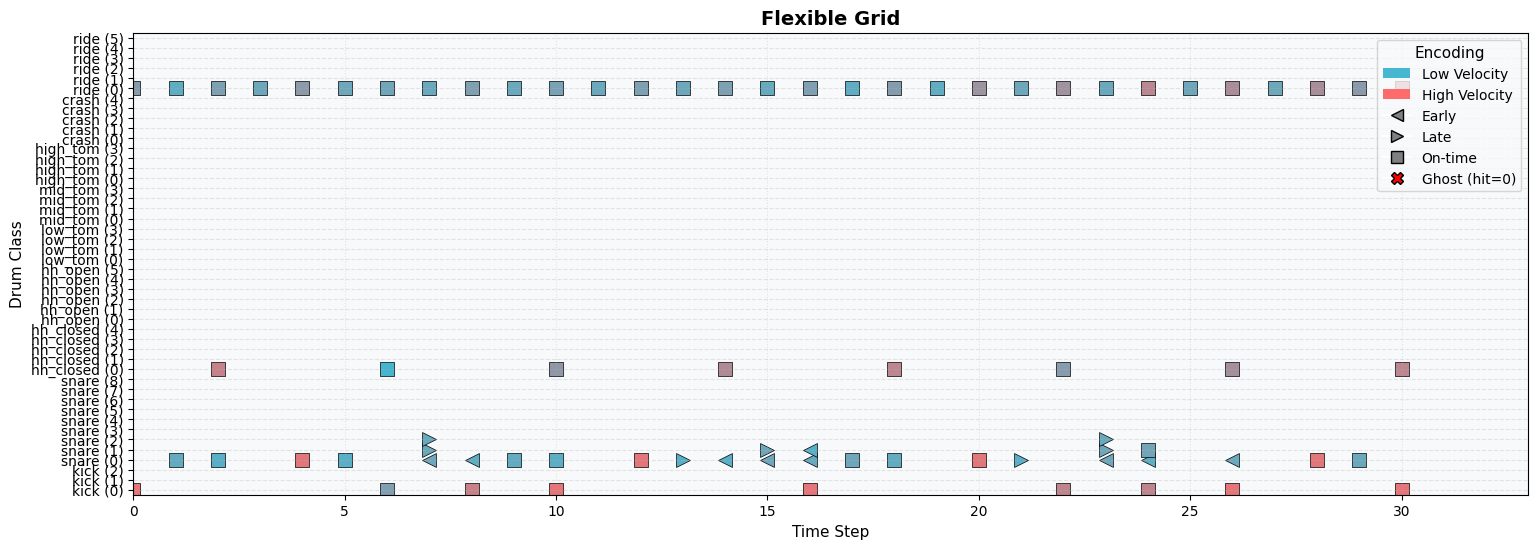

In [48]:
flexible_grid, stats = feature.to_flexible_grid(max_hits_per_class=GrooveIQStats.max_hits_per_class, steps_per_quarter=4)
feature.flexible_grid_plot(max_hits_per_class=GrooveIQStats.max_hits_per_class, steps_per_quarter=4)
print(stats)

## Distances

Computing per-feature distances: 100%|██████████| 11/11 [00:00<00:00, 32.20it/s]


(<Figure size 1500x1200 with 11 Axes>,
 array([[<Axes: title={'center': 'KDE: total_density'}, xlabel='Distance', ylabel='Density'>,
         <Axes: title={'center': 'KDE: total_complexity'}, xlabel='Distance', ylabel='Density'>,
         <Axes: title={'center': 'KDE: total_average_intensity'}, xlabel='Distance', ylabel='Density'>],
        [<Axes: title={'center': 'KDE: lowness'}, xlabel='Distance', ylabel='Density'>,
         <Axes: title={'center': 'KDE: midness'}, xlabel='Distance', ylabel='Density'>,
         <Axes: title={'center': 'KDE: highness'}, xlabel='Distance', ylabel='Density'>],
        [<Axes: title={'center': 'KDE: combined_syncopation'}, xlabel='Distance', ylabel='Density'>,
         <Axes: title={'center': 'KDE: polyphonic_syncopation'}, xlabel='Distance', ylabel='Density'>,
         <Axes: title={'center': 'KDE: laidbackness'}, xlabel='Distance', ylabel='Density'>],
        [<Axes: title={'center': 'KDE: swingness'}, xlabel='Distance', ylabel='Density'>,
         <A

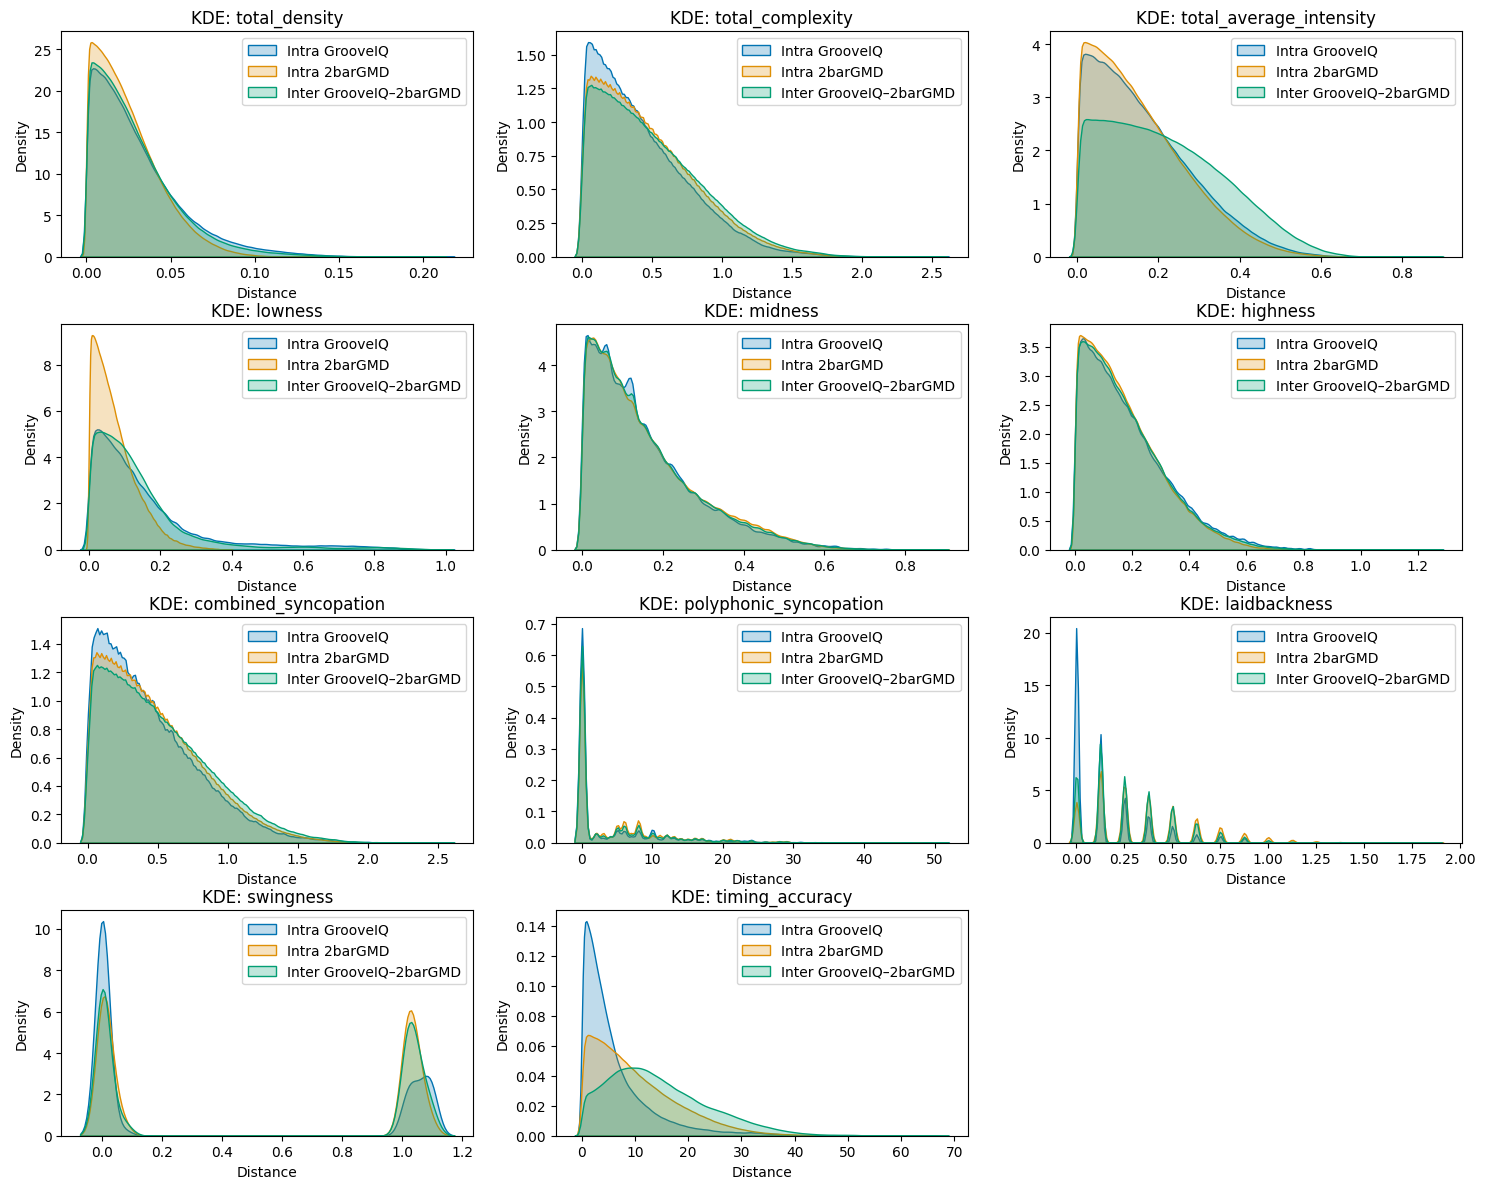

In [ ]:
giq_eval_dict = {key: np.array(value) for key, value in giq_eval_dict.items()}
gmd_eval_dict = {key: np.array(value) for key, value in gmd_eval_dict.items()}

dists = compute_per_feature_distances(giq_eval_dict, gmd_eval_dict)
#plot_kde_grid_per_feature(dists, A_label="GrooveIQ", B_label="2barGMD", ncols=3, figsize=(15, 12) )